In [1]:
import FCA, pickle, csv
import numpy as np
import pandas as pd
import networkx as nx
import statistics as s
from math import floor
from NNetwork import NNetwork as nn
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings("ignore")

import random

from sklearn.manifold import SpectralEmbedding

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
sampler = RandomUnderSampler()

from karateclub import Node2Vec
from karateclub import Graph2Vec


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as rf

In [2]:
def model_metrics(model, y_test, y_pred):
    conf_matrix = confusion_matrix(y_true = y_test, y_pred = y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                  display_labels=model.classes_)
    disp.plot()
    plt.show()
    
    print('Precision: %.3f' % precision_score(y_test, y_pred))
    print('Recall: %.3f' % recall_score(y_test, y_pred))
    print('F1: %.3f' % f1_score(y_test, y_pred))
    print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
    
    pass
    return

In [3]:
# FCA_iter: total iteration for the FCA model, used for label
# baseline_iter: the iteration for baseline model, usually less than FCA_iter
# iter_include: number of iteration to include in the dataframe
# X: a list of graph structure (for each graph, length = k^2 if num_nodes=k)
# num_edges, num_nodes, min_degree, max_degree, diameter, quartile_1, quartile_2, quartile_3, states, y, baseline_width
def FCA_datagen(num_nodes, kappa, FCA_iter, baseline_iter, iter_include, file_name, X):
    # generate the toy dataset
    file = open(file_name, 'w+', newline='')

    header = ["num_edges", "num_nodes", "min_degree", "max_degree", "diameter", "quartile_1",
              "quartile_2", "quartile_3", "y", "baseline_width"]
    for i in range(baseline_iter):
        for j in range(num_nodes):
            header.append("s" + str(i + 1) + "_" + str(j + 1))

    with file:
        write = csv.writer(file)

        write.writerow(header)
        for i in range(X.shape[1]): #X.shape = (400, 3000)
            G=nx.from_pandas_adjacency(pd.DataFrame(X[:,i].reshape(20, -1)))
            G=nx.Graph(G)
            
            
            col = np.random.randint(0,kappa,size=num_nodes)

            num_edges = G.number_of_edges()
            min_degree = min(list(G.degree), key=lambda x: x[1])[1]
            max_degree = max(list(G.degree), key=lambda x: x[1])[1]
            diameter = nx.diameter(G)
            quartile_1 = s.quantiles(col, n=4)[0]
            quartile_2 = s.quantiles(col, n=4)[1]
            quartile_3 = s.quantiles(col, n=4)[2]

            sample = [num_edges, num_nodes, min_degree, max_degree, diameter,
                      quartile_1, quartile_2, quartile_3]
            states, label = FCA.FCA(G, col, kappa, FCA_iter)

            width = FCA.width_compute(states[FCA_iter - 1], kappa)
            y = False
            if (width < floor(kappa / 2)):  # half circle concentration
                y = True
            sample.append(y)

            baseline_width = FCA.width_compute(states[baseline_iter - 1], kappa)
            baseline = False
            if (baseline_width < floor(kappa / 2)):  # half circle concentration
                baseline = True
            sample.append(baseline)

            for j in range(iter_include):
                sample = sample + list(states[j])

            write.writerow(sample)
    #return graph_list

In [4]:
sampling_alg = 'pivot'

ntwk = 'UCLA26' # COVID_PPI, Wisconsin87, UCLA26, Caltech36
ntwk_nonumber = ''.join([i for i in ntwk if not i.isdigit()])
save_folder = 'Subgraph_sampling/test1/'

path = "../Data/Networks_all_NDL/" + str(ntwk) + '.txt'
G = nn.NNetwork()
G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
print('num nodes in G', len(G.nodes()))
print('num edges in G', len(G.get_edges()))

num nodes in G 20467
num edges in G 1495226


In [5]:
k=20
X, embs = G.get_patches(k=k, sample_size=1000, skip_folded_hom=True)
# file = open('toy.pkl', 'wb')
# pickle.dump(X, file)
# file.close()
X.shape

num of subgraphs induced on k-paths: 1000


(400, 1000)

In [6]:
num_nodes = 20
kappa = 10
FCA_iter = 200
baseline_iter = 50
iter_include = 5
file_name = "toy.csv"
FCA_datagen(num_nodes, kappa, FCA_iter, baseline_iter, iter_include, file_name, X)

In [7]:
df = pd.read_csv("toy.csv")
df

,num_edges,num_nodes,min_degree,max_degree,diameter,quartile_1,quartile_2,quartile_3,y,baseline_width,...,s50_11,s50_12,s50_13,s50_14,s50_15,s50_16,s50_17,s50_18,s50_19,s50_20
0,25,20,1,4,14,2.25,5.0,7.00,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,31,20,1,6,9,2.00,5.0,8.00,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,23,20,1,3,15,2.25,6.0,8.00,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,24,20,1,4,12,2.00,3.5,6.00,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21,20,1,4,17,2.00,4.0,5.75,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,29,20,1,6,6,2.00,4.5,7.00,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,19,20,1,2,19,2.25,4.0,8.00,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,23,20,1,4,10,3.00,5.0,7.00,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,25,20,1,4,10,2.25,4.5,6.75,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df.y.value_counts()

True     706
False    294
Name: y, dtype: int64

In [9]:
df.baseline_width.value_counts()

False    827
True     173
Name: baseline_width, dtype: int64

In [10]:
df.shape

(1000, 1010)

In [11]:
X_adj = X.T
X_adj.shape

(1000, 400)

### The dimension of the projected subspace = 2

In [12]:
embedding = SpectralEmbedding(n_components=2)
X_transformed = embedding.fit_transform(X_adj)
X_transformed.shape

(1000, 2)

In [13]:
y = df.y.astype('int')
y.shape

(1000,)

In [14]:
X_resampled, y_resampled = sampler.fit_resample(X_transformed, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                        test_size = 0.25,
                                                        stratify = y_resampled)

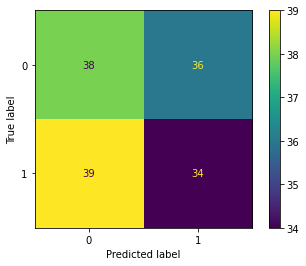

Precision: 0.486
Recall: 0.466
F1: 0.476
Accuracy: 0.490


In [15]:
clf = rf(max_depth=5, max_features="log2")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
model_metrics(clf, y_test, y_pred)

### The dimension of the projected subspace = 10

In [16]:
embedding = SpectralEmbedding(n_components=10)
X_transformed2 = embedding.fit_transform(X_adj)
X_transformed2.shape

(1000, 10)

In [17]:
X_resampled, y_resampled = sampler.fit_resample(X_transformed2, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                        test_size = 0.25,
                                                        stratify = y_resampled)

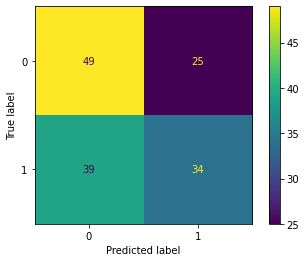

Precision: 0.576
Recall: 0.466
F1: 0.515
Accuracy: 0.565


In [18]:
clf = rf(max_depth=5, max_features="log2")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
model_metrics(clf, y_test, y_pred)

### The dimension of the projected subspace = 100

In [19]:
embedding = SpectralEmbedding(n_components=100)
X_transformed3 = embedding.fit_transform(X_adj)
X_transformed3.shape

(1000, 100)

In [20]:
X_resampled, y_resampled = sampler.fit_resample(X_transformed3, y)
    
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                        test_size = 0.25,
                                                        stratify = y_resampled)

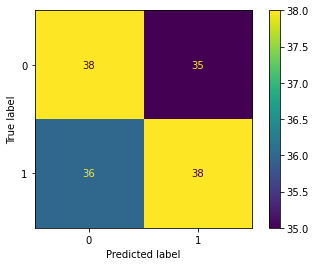

Precision: 0.521
Recall: 0.514
F1: 0.517
Accuracy: 0.517


In [21]:
clf = rf(max_depth=5, max_features="log2")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
model_metrics(clf, y_test, y_pred)

In [22]:
graph_list = []
for i in range(1000):
    G=nx.from_pandas_adjacency(pd.DataFrame(X[:,i].reshape(20, -1)))
    G=nx.Graph(G)
    graph_list.append(G)

In [23]:
len(graph_list)

1000

### node2vec

In [24]:
def n2v_embedding(graph_list):

    df_n2v = pd.DataFrame()

    for graph in graph_list:        
        n2v = Node2Vec(dimensions = 1)
        n2v.fit(graph)
        embed = n2v.get_embedding()
        df_embed = pd.DataFrame(embed.T)
        df_n2v = pd.concat([df_n2v, df_embed], ignore_index=True, axis=0)
        
    return df_n2v


In [25]:
df_n2v = n2v_embedding(graph_list)

KeyboardInterrupt: 

In [ ]:
df_n2v.shape

In [ ]:
X_resampled, y_resampled = sampler.fit_resample(df_n2v, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                        test_size = 0.25,
                                                        stratify = y_resampled)


clf = rf(max_depth=5, max_features="log2")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
model_metrics(clf, y_test, y_pred)

### graph2vec

In [26]:
g2v = Graph2Vec(wl_iterations = 5, dimensions = 10)
g2v.fit(graph_list)
embed = g2v.get_embedding()
df_g2v = pd.DataFrame(embed)

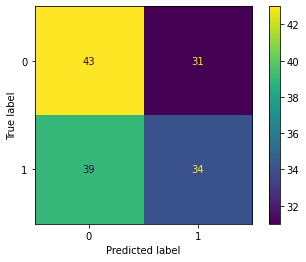

Precision: 0.523
Recall: 0.466
F1: 0.493
Accuracy: 0.524


In [27]:
X_resampled, y_resampled = sampler.fit_resample(df_g2v, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                        test_size = 0.25,
                                                        stratify = y_resampled)


clf = rf(max_depth=5, max_features="log2")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
model_metrics(clf, y_test, y_pred)

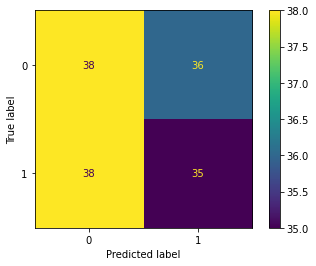

Precision: 0.493
Recall: 0.479
F1: 0.486
Accuracy: 0.497


In [28]:
X_resampled, y_resampled = sampler.fit_resample(X_adj, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                        test_size = 0.25,
                                                        stratify = y_resampled)


clf = rf(max_depth=5, max_features="log2")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
model_metrics(clf, y_test, y_pred)

### Graph Generation by using newman_watts_strogatz_graph

In [64]:
# FCA_iter: total iteration for the FCA model, used for label
# baseline_iter: the iteration for baseline model, usually less than FCA_iter
# iter_include: number of iteration to include in the dataframe
# X: a list of graph structure (for each graph, length = k^2 if num_nodes=k)
# num_edges, num_nodes, min_degree, max_degree, diameter, quartile_1, quartile_2, quartile_3, states, y, baseline_width
def FCA_NWS(num_nodes, num_samples, max_neighbors, kappa, FCA_iter, baseline_iter, iter_include, file_name):
    # generate the toy dataset
    file = open(file_name, 'w+', newline='')

    probability = random.uniform(0, 1)
    graph_list = []
    
    header = ["num_edges", "num_nodes", "min_degree", "max_degree", "diameter", "quartile_1",
              "quartile_2", "quartile_3", "y", "baseline_width"]
    for i in range(baseline_iter):
        for j in range(num_nodes):
            header.append("s" + str(i + 1) + "_" + str(j + 1))

    with file:
        write = csv.writer(file)

        write.writerow(header)
        for i in range(num_samples): 
            neighbors = int(random.uniform(1, max_neighbors))
            G = nx.newman_watts_strogatz_graph(num_nodes, neighbors, probability)
            G=nx.Graph(G)
            
            if nx.is_connected(G):
                
                graph_list.append(G)
            
                col = np.random.randint(0,kappa,size=num_nodes)

                num_edges = G.number_of_edges()
                min_degree = min(list(G.degree), key=lambda x: x[1])[1]
                max_degree = max(list(G.degree), key=lambda x: x[1])[1]
                diameter = nx.diameter(G)
                quartile_1 = s.quantiles(col, n=4)[0]
                quartile_2 = s.quantiles(col, n=4)[1]
                quartile_3 = s.quantiles(col, n=4)[2]

                sample = [num_edges, num_nodes, min_degree, max_degree, diameter,
                          quartile_1, quartile_2, quartile_3]
                states, label = FCA.FCA(G, col, kappa, FCA_iter)

                width = FCA.width_compute(states[FCA_iter - 1], kappa)
                y = False
                if (width < floor(kappa / 2)):  # half circle concentration
                    y = True
                sample.append(y)

                baseline_width = FCA.width_compute(states[baseline_iter - 1], kappa)
                baseline = False
                if (baseline_width < floor(kappa / 2)):  # half circle concentration
                    baseline = True
                sample.append(baseline)

                for j in range(iter_include):
                    sample = sample + list(states[j])

                write.writerow(sample)
    return graph_list

### Max_Neighbors = 5

In [69]:
num_nodes = 20
num_samples = 10000
max_neighbors = 5
kappa = 10
FCA_iter = 200
baseline_iter = 50
iter_include = 5
file_name = "max_neighbors=5.csv"
new_graph_list = FCA_NWS(num_nodes, num_samples, max_neighbors, kappa, FCA_iter, baseline_iter, iter_include, file_name)

In [70]:
df = pd.read_csv("max_neighbors=5.csv")
df

,num_edges,num_nodes,min_degree,max_degree,diameter,quartile_1,quartile_2,quartile_3,y,baseline_width,...,s50_11,s50_12,s50_13,s50_14,s50_15,s50_16,s50_17,s50_18,s50_19,s50_20
0,37,20,2,6,4,4.25,5.5,6.75,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,36,20,2,5,4,2.50,6.0,8.00,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,73,20,6,10,3,1.25,6.0,8.00,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,70,20,4,10,3,2.25,5.0,7.75,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,36,20,2,6,4,1.00,3.0,4.75,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7494,74,20,5,9,3,1.00,3.0,6.00,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7495,37,20,2,6,4,1.00,2.0,5.75,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7496,36,20,2,6,4,1.00,2.0,3.00,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7497,34,20,2,6,4,1.00,2.5,6.00,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
df.y.value_counts()

True     6183
False    1316
Name: y, dtype: int64

In [72]:
df.baseline_width.value_counts()

False    3835
True     3664
Name: baseline_width, dtype: int64

In [73]:
df.shape

(7499, 1010)

In [74]:
y = df.y.astype('int')
y.shape

(7499,)

### graph2vec on the NWS graph (FCA)

In [75]:
len(new_graph_list)

7499

In [76]:
g2v = Graph2Vec(wl_iterations = 5, dimensions = 10)
g2v.fit(new_graph_list)
embed = g2v.get_embedding()
df_g2v = pd.DataFrame(embed)

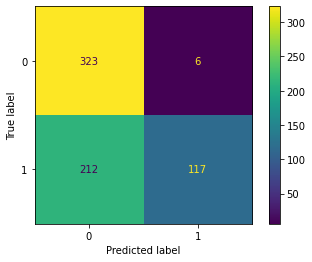

Precision: 0.951
Recall: 0.356
F1: 0.518
Accuracy: 0.669


In [77]:
X_resampled, y_resampled = sampler.fit_resample(df_g2v, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                        test_size = 0.25,
                                                        stratify = y_resampled)


clf = rf(max_depth=5, max_features="log2")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
model_metrics(clf, y_test, y_pred)

In [78]:
y_train.value_counts()

0    987
1    987
Name: y, dtype: int64

In [79]:
y_test.value_counts()

0    329
1    329
Name: y, dtype: int64

### node2vec on the NWS graph (FCA)

In [80]:
def n2v_embedding(graph_list):

    df_n2v = pd.DataFrame()

    for graph in graph_list:        
        n2v = Node2Vec(dimensions = 1)
        n2v.fit(graph)
        embed = n2v.get_embedding()
        df_embed = pd.DataFrame(embed.T)
        df_n2v = pd.concat([df_n2v, df_embed], ignore_index=True, axis=0)
        
    return df_n2v

In [62]:
df_n2v = n2v_embedding(new_graph_list)

X_resampled, y_resampled = sampler.fit_resample(df_n2v, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                        test_size = 0.25,
                                                        stratify = y_resampled)


clf = rf(max_depth=5, max_features="log2")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
model_metrics(clf, y_test, y_pred)

KeyboardInterrupt: 

### Input only contains Adjacency Matrices:

In [81]:
def adj_matrices(graph_list):
    
    df = pd.DataFrame()
    
    for G in graph_list:
        adj_matrix = nx.adjacency_matrix(G).todense()
        vectorized_adj = adj_matrix.reshape(1, 400)
        temp = pd.DataFrame(vectorized_adj)
        df = pd.concat([df, temp], axis=0, ignore_index=True)
        
    return df

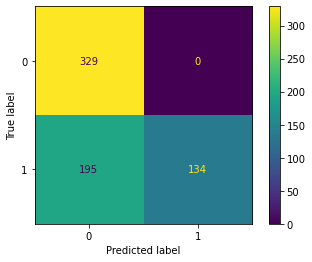

Precision: 1.000
Recall: 0.407
F1: 0.579
Accuracy: 0.704


In [82]:
X_resampled, y_resampled = sampler.fit_resample(adj_matrices(new_graph_list), y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                        test_size = 0.25,
                                                        stratify = y_resampled)


clf = rf(max_depth=5, max_features="log2")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
model_metrics(clf, y_test, y_pred)

### Max_Neighbors = 15

In [84]:
num_nodes = 20
num_samples = 10000
max_neighbors = 15
kappa = 10
FCA_iter = 200
baseline_iter = 50
iter_include = 5
file_name = "max_neighbors=15.csv"
new_graph_list = FCA_NWS(num_nodes, num_samples, max_neighbors, kappa, FCA_iter, baseline_iter, iter_include, file_name)

In [85]:
df = pd.read_csv("max_neighbors=15.csv")
df

,num_edges,num_nodes,min_degree,max_degree,diameter,quartile_1,quartile_2,quartile_3,y,baseline_width,...,s50_11,s50_12,s50_13,s50_14,s50_15,s50_16,s50_17,s50_18,s50_19,s50_20
0,182,20,16,19,2,2.00,4.0,7.50,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,190,20,19,19,1,2.25,4.0,6.00,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,116,20,8,14,2,1.00,4.5,6.75,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,185,20,17,19,2,1.25,3.5,6.75,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,181,20,16,19,2,2.50,5.0,8.00,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9278,183,20,17,19,2,1.25,4.0,6.00,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9279,117,20,8,14,2,2.00,3.5,7.00,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9280,79,20,4,10,3,2.00,4.5,7.50,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9281,150,20,11,18,2,3.25,5.0,7.00,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
df.y.value_counts()

True     8996
False     287
Name: y, dtype: int64

In [87]:
df.baseline_width.value_counts()

True     7721
False    1562
Name: baseline_width, dtype: int64

In [88]:
y = df.y.astype('int')
y.shape

(9283,)

In [89]:
g2v = Graph2Vec(wl_iterations = 5, dimensions = 10)
g2v.fit(new_graph_list)
embed = g2v.get_embedding()
df_g2v = pd.DataFrame(embed)

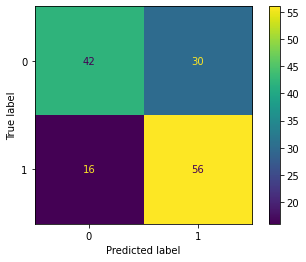

Precision: 0.651
Recall: 0.778
F1: 0.709
Accuracy: 0.681


In [90]:
X_resampled, y_resampled = sampler.fit_resample(df_g2v, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                        test_size = 0.25,
                                                        stratify = y_resampled)


clf = rf(max_depth=5, max_features="log2")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
model_metrics(clf, y_test, y_pred)

In [91]:
y_train.value_counts()

1    215
0    215
Name: y, dtype: int64

In [92]:
y_test.value_counts()

1    72
0    72
Name: y, dtype: int64

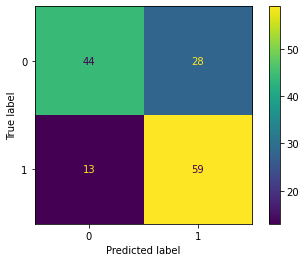

Precision: 0.678
Recall: 0.819
F1: 0.742
Accuracy: 0.715


In [93]:
X_resampled, y_resampled = sampler.fit_resample(adj_matrices(new_graph_list), y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                        test_size = 0.25,
                                                        stratify = y_resampled)


clf = rf(max_depth=5, max_features="log2")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
model_metrics(clf, y_test, y_pred)